2
2


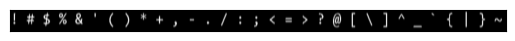

In [32]:
import cv2 as cv
import numpy as np
import scipy as sp
import os
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

key = "AaBbCcDdEeFfGgHhIiJjKkLlMmNnOoPpQqRrSsTtUuVvWwXxYyZz!#$%&'()*+,-./:;<=>?@[]^_`{|}~"
key = list(key)


def get_characters(image, folder = None, offset = 0, stop = -1):
    img = cv.imread(image, cv.IMREAD_GRAYSCALE)
    plt.imshow(img,'gray',vmin=0,vmax=255)
    _, thresh1 = cv.threshold(img,127,255,cv.THRESH_BINARY_INV)
    thresh1 = gaussian_filter(thresh1, (2,0)) #vertical gaussian blur to account for 'i', ':', etc...


    plt.imshow(thresh1,'gray',vmin=0,vmax=255)
    plt.xticks([]),plt.yticks([])
    contours, _ = cv.findContours(thresh1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)


    contours = sorted(contours, key=lambda c: cv.boundingRect(c)[0])
    chars = [] 
    space = []
    for i, c in enumerate(contours):
        if (i == stop):
            break

        x, y, w, h = cv.boundingRect(c) #create bounding box per character
        char = img[y:y+h, x - 1:x + w + 1]
        char = square_image(char) # square image to make it easier to compare
        chars.append(char)

        if folder != None:
            path = folder + 'char_'+ str(i + offset)+'.png'
            cv.imwrite(path, char)

        xSpace = [x, w]
        space.append(xSpace)

    return chars, space

def process_by_rows(image_name, bag = None, getBoxes = False):

    img = cv.imread(image_name, cv.IMREAD_GRAYSCALE)
    _, thresh = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)
    thresh = gaussian_filter(thresh, (2,30)) #horizontal gaussian blur to find rows of text

    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv.boundingRect(c)[1])
    print(len(contours))

    rows = []
    for c in contours:
        x, y, w, h = cv.boundingRect(c)
        row = img[y:y+h, x:x+w]
        rows.append(row)
    chars = []
    space = []

    i = 0
    for row in rows:
        if (bag != None):
            if i == 0:
                get_characters_from_row(row, folder=bag)
                i += 1
            else:
                get_characters_from_row(row, offset = 52, folder = bag)
        c, s = get_characters_from_row(row, getBox = getBoxes)
        for char in c:
            chars.append(square_image(char)) # square image to make it easier to compare
        for vals in s:
            space.append(vals)
    
    if (getBoxes): #for visualization
        for c in contours:
            x, y, w, h = cv.boundingRect(c)
            cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green rectangles
            cv.rectangle(thresh, (x, y), (x + w, y + h), (0, 255, 0), 2)
        plt.figure()
        plt.imshow(img, cmap="grey")
        plt.figure()
        plt.imshow(thresh, cmap="grey")
        plt.figure()
    return chars, space


def get_characters_from_row(row, offset = 0, folder = None, getBox = False):

    _, thresh = cv.threshold(row, 127, 255, cv.THRESH_BINARY_INV)
    thresh = gaussian_filter(thresh, (2,0)) #vertical gaussian blur to account for 'i', ':', etc...

    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=lambda c: cv.boundingRect(c)[0])
    chars = []
    space = []
    
    for i, c in enumerate(contours):
        x, y, w, h = cv.boundingRect(c) #create bounding box per character
        char = row[y:y+h, x - 1:x + w + 1]
        char = square_image(char)
        chars.append(char)
        xSpace = [x, w]
        space.append(xSpace)
    
        if (folder != None):
            path = folder + 'char_'+ str(i + offset)+'.png'
            cv.imwrite(path, char)
    
    if (getBox): #for visualization
        for c in contours:
            x, y, w, h = cv.boundingRect(c)
            cv.rectangle(row, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green rectangles
        plt.figure()
        plt.imshow(row, cmap="grey")
    return chars, space

def square_image(img):
    h, w = img.shape
    if h > w:
        diff = h - w
        img = cv.copyMakeBorder(img, 0, 0, diff//2, diff//2, cv.BORDER_CONSTANT, value=255)
    elif w > h:
        diff = w - h
        img = cv.copyMakeBorder(img, diff//2, diff//2, 0, 0, cv.BORDER_CONSTANT, value=255)
    return img




#https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
def compare(char1, char2): 
    sift = cv.SIFT_create()
    bf = cv.BFMatcher()
    
    keypoints1, descriptors1 = sift.detectAndCompute(char1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(char2, None)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2) #k-best matches
    good_matches = []
    if matches is None:
        return 0
    for m, n in matches:
        if m.distance < .65 * n.distance: #?Ratio Test
            good_matches.append(m)

    similarity = len(good_matches) / max(len(keypoints1), len(keypoints2))

    return similarity

def compare_by_diff(char1, char2, show = False):
    _ , c1 = cv.threshold(char1, 127, 255, cv.THRESH_BINARY)
    _ , c2 = cv.threshold(char1, 127, 255, cv.THRESH_BINARY)

    val = cv.absdiff(char1, char2)/255

    mean = cv.mean(val)[0]
    if(show):
        plt.imshow(val, cmap='gray')
        plt.show()
        print(mean)
        
    return mean

def rescale_by_height(image, target_height, method=cv.INTER_LANCZOS4):
    w = int(round(target_height * image.shape[1] / image.shape[0]))
    return cv.resize(image, (w, target_height), interpolation=method)


def rescale_by_height_and_width(image, target_height, target_width, method=cv.INTER_LANCZOS4):
    return cv.resize(image, (target_width, target_height), interpolation=method)


def best_match(img, bag):
    list = np.zeros(82)
    for i in range(82):
        cmp = cv.imread((bag + 'char_' + str(i) + '.png'), cv.IMREAD_GRAYSCALE)
        cmp = rescale_by_height_and_width(cmp, 720, 720)
        imgR = rescale_by_height_and_width(img, 720, 720)
        list[i] = compare_by_diff(cmp, imgR)
    
    # print(np.argmin(list))
    return np.argmin(list), list
    

def to_text(characters, space, bag):
    thresh = 1.04
    out = ''
    i = 0
    avg = 0

    for s in space: 
        avg += s[1]
    avg = avg / len(space)

    print(bag)

    for char in characters:
        if (i != 0):
            currx, currw = space[i]
            prevx, prevw = space[i - 1]
            # print("i: " + str(-1 *  ((prevx + prevw) - currx)) + ' V: ' + str(avg * thresh))
            if (currx < prevx):
                out += '\n'
            elif(-1 *  ((prevx + prevw) - currx) > (avg * thresh)):
                out += ' '
        temp = key[best_match(char, bag)[0]]
        # print(temp)
        out += temp
        i += 1
    return out

def image_to_string(image_name, bag = './bag/', getBox = False):
    characters, space = process_by_rows(image_name, getBoxes = getBox)
    return to_text(characters, space, bag)

def make_bag(image, bag):
    process_by_rows(image, bag)

def similarity(string1, string2, ignore_capitals = False):
    
    if ignore_capitals:
        str1 = string1.lower()
        str2 = string2.lower()
    else: 
        str1 = string1
        str2 = string2
    
    match_count = sum(1 for char1, char2 in zip(str1, str2) if char1 == char2)
    
    percentage = (match_count / max(len(str1), len(str2))) * 100
    
    return percentage

def read_text_file(file_path):
    try:
        with open(file_path, 'r') as file:
            text = file.read()
        return text
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
        return None


get_characters('./image1.png', folder='./bag/')
get_characters('./image3.png', folder='./bag/', offset=52)
make_bag('./Menlo.png', './bag2/')
make_bag('./TimesNew.png', './bag3/')

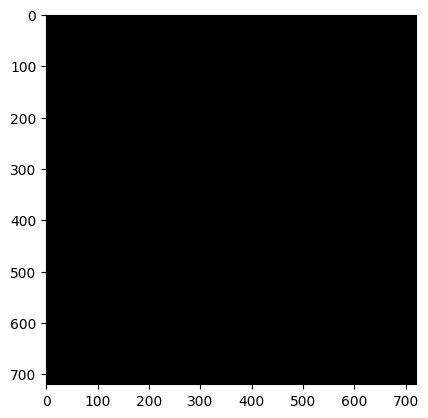

0.0


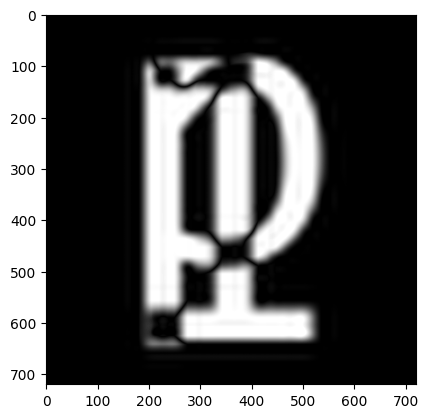

0.21389163489469418


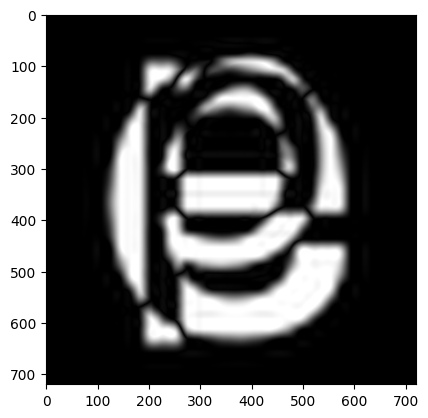

0.20849143669813977


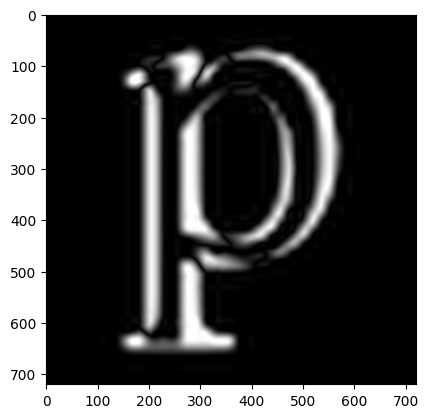

0.10894502693054164
8
./bag/
One bright morning, aS the Sun painted the Sky with hueS of orange and pink,
Maya Set out on a journey into the mySteriouS wooUS that borUereU her
village. Armed with only her witS and a Small baCkpaCk, She ventured deeper
into the foreSt, CuriouS to explore what lay beyond the familiar pathS.
AS Maya wandered through the towering treeS and tangled undergrowth, She
Stumbled upon an anCient Stone bridge arChing graCefully over a babbling
brook. lntrigued by itS weathered beauty, Maya CroSSed the bridge, feeling a
SenSe of exCitement tingle in the air.
92.26618705035972
98.02158273381295


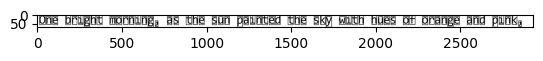

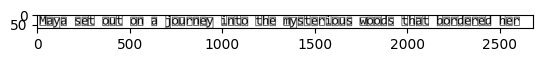

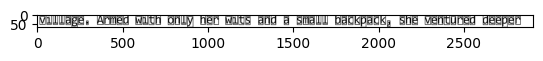

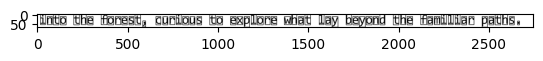

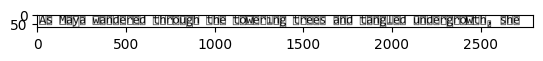

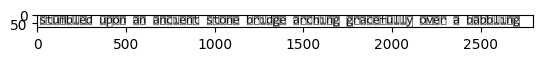

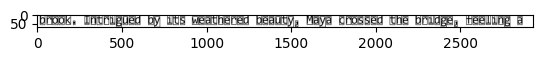

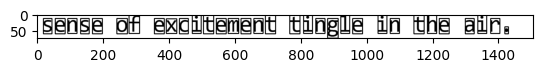

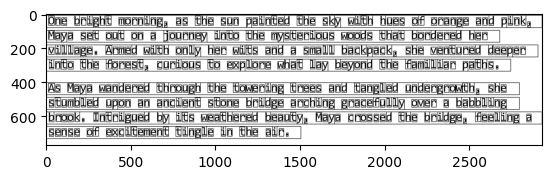

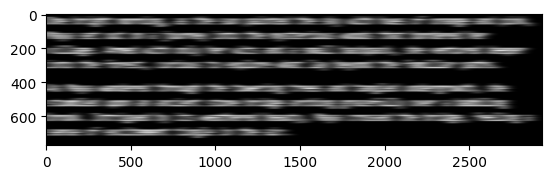

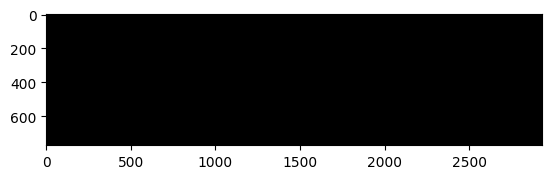

In [31]:
t1 = rescale_by_height_and_width(cv.imread('./bag/char_31.png', cv.IMREAD_GRAYSCALE), 720, 720)
t2 = rescale_by_height_and_width(cv.imread('./bag/char_23.png', cv.IMREAD_GRAYSCALE), 720, 720)
t3 = rescale_by_height_and_width(cv.imread('./bag2/char_9.png', cv.IMREAD_GRAYSCALE), 720, 720)
t4 = rescale_by_height_and_width(cv.imread('./bag3/char_31.png', cv.IMREAD_GRAYSCALE), 720, 720)

compare_by_diff(t1 , t1, True) #itself
compare_by_diff(t1 , t2, True) #same font, diff char
compare_by_diff(t1 , t3, True) #diff font & char
compare_by_diff(t1 , t4, True) #diff font, same char

Correct = read_text_file('./Example1.txt')
t1 = image_to_string('Example1.png', getBox=True)
print(t1)
print(similarity(Correct, t1))
print(similarity(Correct, t1, True))

# get_characters('image2.png', './saved/')

# t1 = rescale_by_height_and_width(t1, 720, 720)
# t2 = rescale_by_height_and_width(t2, 720, 720)

# compare_by_diff(t1, t2)
# plt.imshow(t1, cmap='gray')
# # plt.show()
# # plt.imshow(t2, cmap='gray')
# # plt.show()

# test1, space1 = get_characters('image2.png')

# test2, space2 = process_by_rows('image6.png')

# for i, t in enumerate(test1):
#     plt.imshow(t, cmap='gray')
#     plt.show()

# ind1 = best_match(t1, './bag/')
# print(ind1)

# ind2 = best_match(t2, './bag/')
# print(ind2)

# t2f = cv.GaussianBlur(t2, (27, 27), 0)
# ind2f = best_match(t2f, './bag/')
# print(ind2f)

# text = to_text(test2, space2)
# print(text)



# t2 = image_to_string('image2.png', './bag2/')
# print(t2)
# print(similarity(Correct, t2))
# print(similarity(Correct, t2, True))

# t3 = image_to_string('image2.png', './bag3/')
# print(t3)
# print(similarity(Correct, t3))
# print(similarity(Correct, t3, True))




In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread('./bag/char_9.png',cv.IMREAD_GRAYSCALE) # queryImage
img2 = cv.imread('./saved/char_3.png',cv.IMREAD_GRAYSCALE) # trainImage
# img1 = cv.imread('./light_cubes_base',cv.IMREAD_GRAYSCALE) # queryImage
# img2 = cv.imread('./light_cubes_sm',cv.IMREAD_GRAYSCALE) # queryImage

def rescale_by_height(image, target_height, method=cv.INTER_LANCZOS4):
    """Rescale `image` to `target_height` (preserving aspect ratio)."""
    w = int(round(target_height * image.shape[1] / image.shape[0]))
    return cv.resize(image, (w, target_height), interpolation=method)

def rescale_by_height_and_width(image, target_height, target_width, method=cv.INTER_LANCZOS4):
    return cv.resize(image, (target_width, target_height), interpolation=method)


img1 = rescale_by_height_and_width(img1, 400, 270)
img2 = rescale_by_height_and_width(img2, 400, 270)

# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


/var/folders/7b/zk31sn6j2jd6mgfb45v946240000gn/T/ipykernel_31596/958572516.py:9: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  H_blur = sp.ndimage.filters.gaussian_filter(thresh1, (2,30))
/var/folders/7b/zk31sn6j2jd6mgfb45v946240000gn/T/ipykernel_31596/958572516.py:10: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  thresh1 = sp.ndimage.filters.gaussian_filter(thresh1, (2,0))


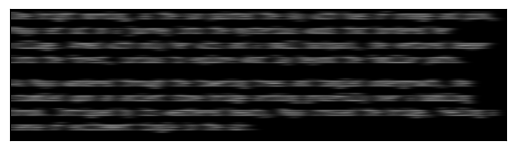

In [81]:
import cv2 as cv
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

img = cv.imread('image5.png', cv.IMREAD_GRAYSCALE)
plt.imshow(img,'gray',vmin=0,vmax=255)
_, thresh1 = cv.threshold(img,127,255,cv.THRESH_BINARY_INV)
H_blur = sp.ndimage.filters.gaussian_filter(thresh1, (2,30))
thresh1 = sp.ndimage.filters.gaussian_filter(thresh1, (2,0))


plt.imshow(H_blur,'gray',vmin=0,vmax=255)
plt.xticks([]),plt.yticks([])
contours, _ = cv.findContours(thresh1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
rows, _ = cv.findContours(H_blur, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)


rows = sorted(rows, key=lambda c: cv.boundingRect(c)[1])
contours = sorted(contours, key=lambda c: cv.boundingRect(c)[0])
chars = []
for i, c in enumerate(contours):
    x, y, w, h = cv.boundingRect(c)

    char = img[y:y+h, x:x+w]
    chars.append(char)
    path = './saved/' + 'char_'+str(i)+'.png'
    cv.imwrite(path, char)

for i, c in enumerate(rows):
    x, y, w, h = cv.boundingRect(c)

    row = img[y:y+h, x:x+w]
    path = './saved/' + 'row_'+str(i)+'.png'
    cv.imwrite(path, row)


def rescale_by_height_and_width(image, target_height, target_width, method=cv.INTER_LANCZOS4):
    return cv.resize(image, (target_width, target_height), interpolation=method)

In [12]:
import pytesseract as tess

print(tess.image_to_string('image6.png'))

ModuleNotFoundError: No module named 'pytesseract'

(([], []), ([], []))

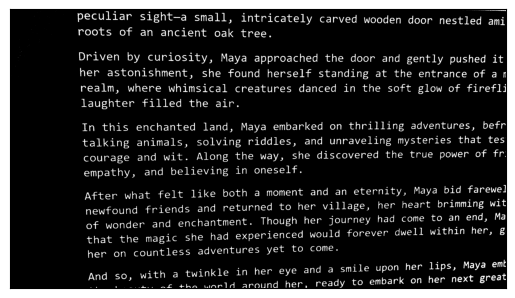

In [43]:
img = cv.imread("image6.png", cv.IMREAD_GRAYSCALE)
plt.imshow(img,'gray',vmin=0,vmax=255)
_, thresh1 = cv.threshold(img,90,255,cv.THRESH_BINARY_INV)

plt.imshow(thresh1,'gray',vmin=0,vmax=255)
plt.xticks([]),plt.yticks([])

https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
https://stackoverflow.com/questions/43820256/accounting-for-i-and-j-dots-in-ocr-python